In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.mixture import GaussianMixture
plt.style.use('ggplot')

In [2]:
df = pd.read_excel('rb2018.xlsx')
df['TD/G'] = df['TD'] / df['G']

### Cluster 2018 RBs into Tiers

In [3]:
X = df[['Rk','G', 'GS', 'Att', 'Yds', 'TD',
        'Lng', 'Y/A', 'Y/G', 'Fmb', 'TD/G']].values
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))
        if bic[-1] < lowest_bic and aic[-1] < lowest_aic:
            lowest_bic = bic[-1]
            lowest_aic = aic[-1]
            best_gmm = gmm
            
best_gmm.fit(X)
tier = best_gmm.predict(X)
df['tier'] = tier

In [4]:
l = []
for item in tier:
    if item not in l:
        l.append(item)
tier_ranks = []
for i in range(len(np.unique(tier))):
    tier_ranks.append((i,l[i]))
tier_ranks = sorted(tier_ranks, key=lambda tup: tup[1])
ordered_ranks = list(i+1 for i in range(len(tier_ranks)))
ordered_ranking = []
for i in tier:
    loc = l.index(i)
    ordered_ranking.append(ordered_ranks[loc])
    
df['tier'] = ordered_ranking

In [5]:
df['tier_min_y/g'] = df.groupby('tier')['Y/G'].transform('min')
df['tier_avg_y/g'] = df.groupby('tier')['Y/G'].transform('mean')
df['tier_max_y/g'] = df.groupby('tier')['Y/G'].transform('max')
df['tier_min_td/g'] = df.groupby('tier')['TD/G'].transform('min')
df['tier_avg_td/g'] = df.groupby('tier')['TD/G'].transform('mean')
df['tier_max_td/g'] = df.groupby('tier')['TD/G'].transform('max')

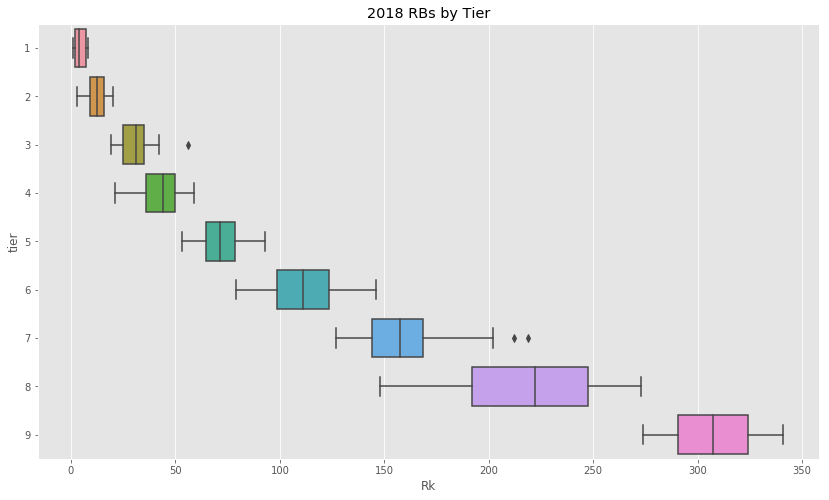

In [6]:
plt.figure(figsize=(14,8))
plt.title("2018 RBs by Tier")
ax = sns.boxplot(data=df, x='Rk', y='tier', orient="h")

### Upload Week 1 Rankings

In [7]:
df2 = pd.read_csv('2019_wk_1_rb.csv')
df2 = df2.drop(['Tier','WSIS'],axis=1)

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 8 columns):
Rank             154 non-null float64
Running Backs    154 non-null object
Team             154 non-null object
Opp              138 non-null object
Best             154 non-null float64
Worst            154 non-null float64
Avg              154 non-null float64
Std Dev          154 non-null float64
dtypes: float64(5), object(3)
memory usage: 9.8+ KB


In [9]:
df2.tail()

,Rank,Running Backs,Team,Opp,Best,Worst,Avg,Std Dev
151,152.0,Andre Ellington,FA,NaN,115.0,120.0,117.5,2.5
152,153.0,Jamize Olawale,DAL,vs. NYG,117.0,125.0,121.0,4.0
153,154.0,Senorise Perry,BUF,at NYJ,131.0,133.0,132.0,1.0
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df2 = df2[0:154]

In [11]:
X = df2[['Rank','Best', 'Worst', 'Avg','Std Dev']].values
lowest_bic = np.infty
lowest_aic = np.infty
bic = []
aic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        aic.append(gmm.aic(X))
        if bic[-1] < lowest_bic and aic[-1] < lowest_aic:
            lowest_bic = bic[-1]
            lowest_aic = aic[-1]
            best_gmm = gmm
best_gmm.fit(X)
tier = best_gmm.predict(X)
df2['tier'] = tier

l = []
for item in tier:
    if item not in l:
        l.append(item)

tier_ranks = []
for i in range(len(np.unique(tier))):
    tier_ranks.append((i,l[i]))
tier_ranks = sorted(tier_ranks, key=lambda tup: tup[1])    
ordered_ranks = list(i+1 for i in range(len(tier_ranks)))
ordered_ranking = []
for i in tier:
    loc = l.index(i)
    ordered_ranking.append(ordered_ranks[loc])
df2['tier'] = ordered_ranking

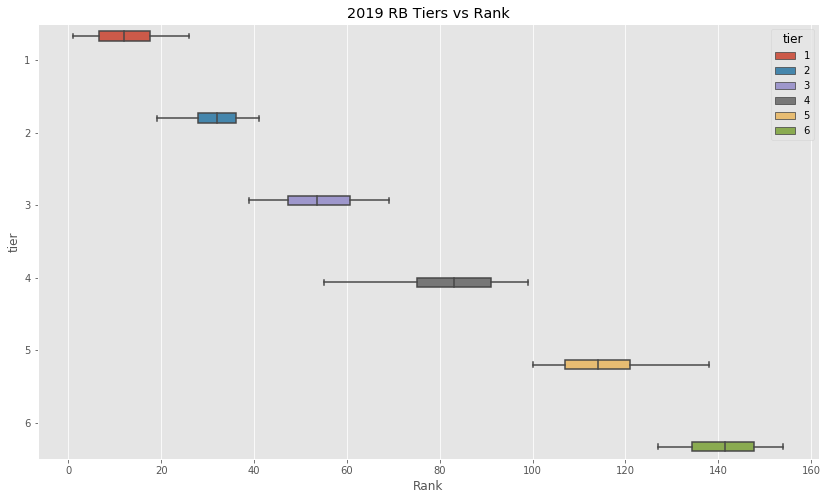

In [12]:
plt.figure(figsize=(14,8))
plt.title("2019 RB Tiers vs Rank")
ax = sns.boxplot(data=df2, x='Rank', y='tier', hue='tier', orient="h")

### Use the 2018 Tier Stats to Create Fantasy Point Projection Ranges

In [13]:
final = df.drop_duplicates('tier')
final = final[['tier','tier_min_y/g','tier_avg_y/g','tier_max_y/g',
               'tier_min_td/g', 'tier_avg_td/g','tier_max_td/g']]

In [14]:
final['fp_min'] = (final['tier_min_y/g'] / 10) + (final['tier_min_td/g'] * 6) 
final['fp_avg'] = (final['tier_avg_y/g'] / 10) + (final['tier_avg_td/g'] * 6) 
final['fp_max'] = (final['tier_max_y/g'] / 10) + (final['tier_max_td/g'] * 6) 
final = final.reset_index(drop=True)

In [15]:
proj = pd.DataFrame(columns=['Running Backs','Team','Opp'])
for t in final.tier.values:
    temp = df2[df2['tier'] == t]
    temp = temp.reset_index(drop=True)
    temp['fp_min'] = final.loc[t-1]['fp_min']
    temp['fp_avg'] = final.loc[t-1]['fp_avg']
    temp['fp_max'] = final.loc[t-1]['fp_max']
    proj = pd.concat([proj,temp],sort=False)

In [16]:
proj = proj[['Running Backs', 'Team', 'Opp', 'tier', 'fp_min', 'fp_avg', 'fp_max']]
proj = proj.reset_index(drop=True)

In [17]:
proj.head()

,Running Backs,Team,Opp,tier,fp_min,fp_avg,fp_max
0,Saquon Barkley,NYG,at DAL,1.0,10.57,12.865286,16.845714
1,Christian McCaffrey,CAR,vs. LAR,1.0,10.57,12.865286,16.845714
2,Alvin Kamara,NO,vs. HOU,1.0,10.57,12.865286,16.845714
3,Dalvin Cook,MIN,vs. ATL,1.0,10.57,12.865286,16.845714
4,Nick Chubb,CLE,vs. TEN,1.0,10.57,12.865286,16.845714


In [18]:
proj.to_csv('rb_wk1_proj.csv',index=False)